In [37]:
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import transforms

import numpy as np


%matplotlib inline

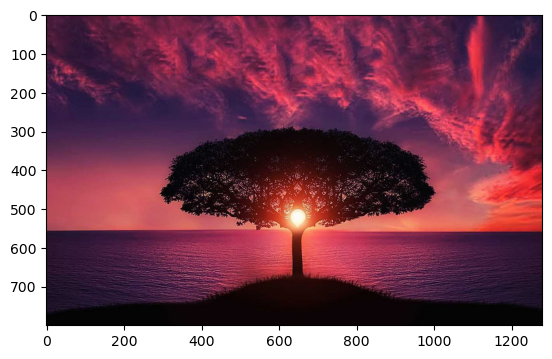

In [2]:
img = cv2.imread('data/zakat-v-webm.jpg')[..., ::-1] #1280*800
plt.imshow(img)
plt.show()

In [5]:
img.shape

(800, 1280, 3)

In [7]:
def im2col(img, kernel_size):
    if len(img.shape) == 3:
        img = img.unsqueeze(0)

    B, C, H, W = img.shape
    kH, kW = kernel_size, kernel_size

    out_h = H - kH + 1
    out_w = W - kW + 1

    columns = torch.zeros((B, C, kH, kW, out_h, out_w), device=img.device)

    for i in range(kH):
        for j in range(kW):
            columns[:, :, i, j, :, :] = img[:, :, i:i + out_h, j:j + out_w]

    columns = columns.permute(0, 1, 4, 5, 2, 3).reshape(B, C * kH * kW, out_h * out_w)

    return columns.squeeze(0)

image_path = "data/tie.jpg"
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_tensor = torch.tensor(image, dtype=torch.float32, device=device).permute(2, 0, 1).unsqueeze(0)  # [B, C, H, W]


columns = im2col(img=image_tensor, kernel_size=3)
print(columns.shape)

torch.Size([27, 9604])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.604488..12.912367].


torch.Size([1, 3, 49, 49])
torch.Size([3, 49, 49])


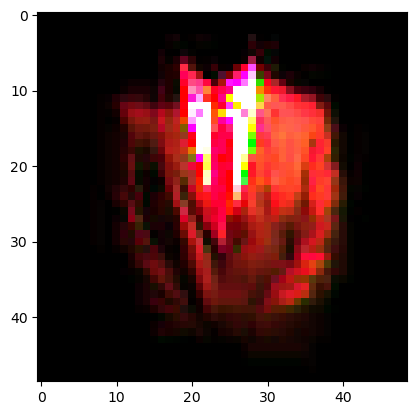

In [63]:
def conv2d_im2col(input_tensor, kernel, bias=None, stride=1):
    B, C, H, W = input_tensor.shape
    out_channels, in_channels, kH, kW = kernel.shape

    assert C == in_channels, "Количество каналов входного изображения должно совпадать с количеством каналов ядра."

    # Вычисляем выходные размеры
    out_h = (H - kH) // stride + 1
    out_w = (W - kW) // stride + 1

    # Используем unfold для извлечения патчей
    patches = input_tensor.unfold(2, kH, stride).unfold(3, kW, stride)  # [B, C, out_h, out_w, kH, kW]
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()  # [B, out_h, out_w, C, kH, kW]
    patches = patches.view(B, out_h * out_w, C * kH * kW)  # [B, out_h*out_w, C*kH*kW]

    # Преобразуем ядро для матричного умножения
    kernel = kernel.view(out_channels, -1)  # [out_channels, C*kH*kW]

    # Выполняем матричное умножение
    output = patches @ kernel.T  # [B, out_h*out_w, out_channels]
    output = output.permute(0, 2, 1).contiguous()  # [B, out_channels, out_h*out_w]
    output = output.view(B, out_channels, out_h, out_w)  # [B, out_channels, out_h, out_w]

    # Добавляем смещение, если оно задано
    if bias is not None:
        output += bias.view(1, -1, 1, 1)

    return output

# Загрузка изображения
image_path = "data/tie.jpg"
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Преобразование в тензор
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_tensor = torch.from_numpy(image).float().permute(2, 0, 1).unsqueeze(0).to(device) / 255.0  # [B, C, H, W]

# Пример ядра свёртки (3x3)
kernel = torch.randn(3, 3, 3, 3, device=device)  # 8 фильтров, 3 входных канала, размер ядра 3x3

# Пример смещения (опционально)
bias = torch.randn(8, device=device)

# Выполнение свёртки
output = conv2d_im2col(image_tensor, kernel, bias=None, stride=2)
print(output.shape)

output = output.squeeze(0);
print(output.shape)
output_np = output.cpu().numpy()
output_np = np.transpose(output_np, (1, 2, 0))
plt.imshow(output_np)

plt.show()